# Optimal Sensor Placement over Segmented Crop Field

This notebook demonstrates how to estimate the optimal sensor placement for a specific crop field within a farm. We combine the following steps:

- We define an overall region for our analysis containing a crop field of interest. We also define a time range to download data for.
- We segment the desired field with `farm_ai/segmentation/segment_s2` workflow.
- We estimate the optimal sensor placement for the segmented field with `farm_ai/sensor/optimal_locations` workflow and visualize the results.


### Micromamba environment setup
To install the required packages, see [this README file](../README.md). You can activate the environment with the following command:


```bash
$ micromamba activate farmvibes-ai
```

### Imports & Setup

In [1]:
import os
import sys
from datetime import datetime

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from shapely import geometry as shpg
from rasterio.features import shapes

from vibe_core.client import get_default_vibe_client
from vibe_core.data.core_types import DataVibe, ExternalReferenceList, gen_guid

# Add shared notebook library to path
sys.path.append("../")
from shared_nb_lib.plot import lw_plot, transparent_cmap
from shared_nb_lib.raster import read_raster, s2_to_img
from shared_nb_lib.utils import create_geojson_file_from_point


# Detecting storage directory
config_dir = os.environ.get("XDG_CONFIG_HOME", os.path.expanduser("~/.config"))
storage_config_path = os.path.join(config_dir, "farmvibes-ai", "storage")
with open(storage_config_path) as f:
    storage_dir = f.read().strip()
print(f"Cache directory set to '{storage_dir}' by reading '{storage_config_path}'")

Cache directory set to '/datadrive/' by reading '/home/azureuser/.config/farmvibes-ai/storage'


## Crop Field Segmentation

Let's instantiate our client and define a geometry and time range of interest for our analysis:


In [41]:
client = get_default_vibe_client()
geom = shpg.Point(-119.11885352165385, 46.434979211782355).buffer(.01, cap_style=3)
time_range = (datetime(2020, 5, 1), datetime(2020, 5, 5))

With those defined, we will download Sentinel-2 data:

In [42]:
# Run the Sentinel-2 download workflow
s2_run = client.run("data_ingestion/sentinel2/preprocess_s2", "S2 - Download", geometry=geom, time_range=time_range)
s2_run.monitor()

Output()

Let's visualize the downloaded raster. For this particular analysis, let's say we are interested in the field in the center of the image:

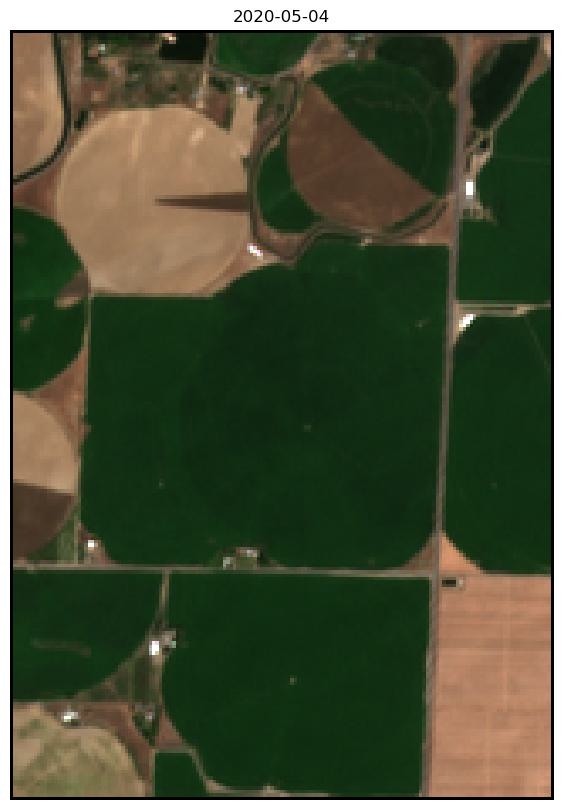

In [43]:
raster = s2_run.output["raster"][0]

# Visualize the downloaded raster and points
plt.figure(figsize=(10, 10))
plt.imshow(s2_to_img(read_raster(raster, geom)[0]))
plt.title(raster.time_range[0].strftime("%Y-%m-%d"))
plt.axis("off")
lw_plot()

We will use the center point as prompts for our segmentation:

In [44]:
# Lat-lon coordinates for those points
point_list = [shpg.Point(geom.centroid.coords[0])]
prompt_ids = [0]
labels = [1]

# Instantiate a geojson with the points to be used for FarmVibes.AI
filepath, gdf, fid = create_geojson_file_from_point(point_list, labels, prompt_ids, storage_dir)
geom_collection = ExternalReferenceList(
        id=f"geo_{fid}", 
        time_range=time_range, 
        geometry=shpg.mapping(geom), 
        assets=[], 
        urls=[filepath]
    )

# Instantiate the workflow run
roi_time_range = DataVibe(id=gen_guid(), time_range=time_range, geometry=shpg.mapping(geom), assets=[])
run = client.run("farm_ai/segmentation/segment_s2", "SAM segmentation", input_data={"user_input": roi_time_range, "prompts": geom_collection})
run.monitor()

/home/azureuser/anaconda3/envs/farmvibes-ai/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:127: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


Output()

Let's visualize each crop field mask output by the workflow:

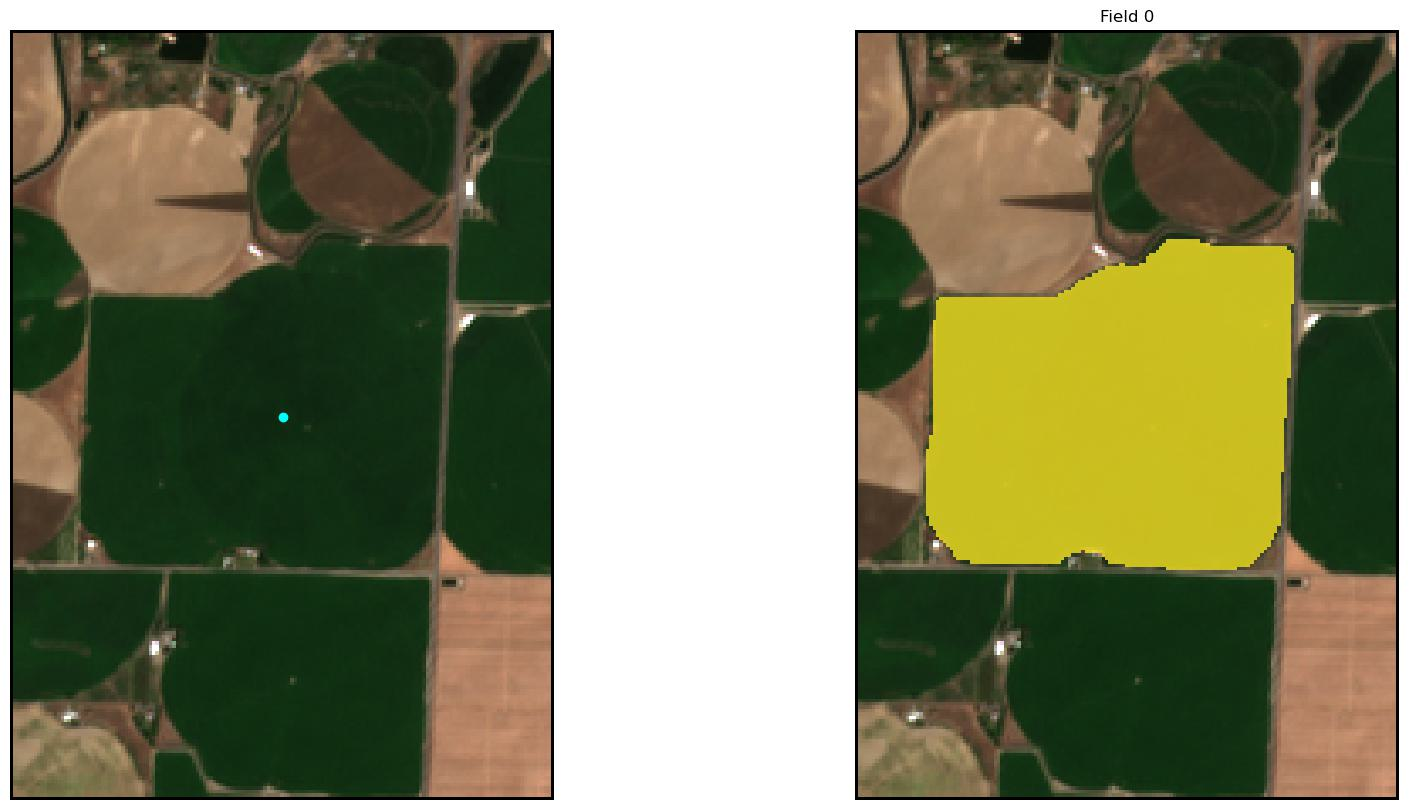

In [45]:
# Reprojecting the raster and points to the same CRS
with rasterio.open(raster.raster_asset.url) as src:
    raster_crs = src.crs
    proj_geom = gpd.GeoSeries(geom, crs="epsg:4326").to_crs(raster_crs).iloc[0].envelope
    shpg_points = list(gdf.to_crs(src.crs)["geometry"])

# Reading the raster
ar, transform = read_raster(run.output["s2_raster"][0], projected_geometry = proj_geom)
img = s2_to_img(ar)

# Reading the segmentation mask
mask_ar, _ = read_raster(run.output["segmentation_mask"][0], projected_geometry = proj_geom)

# Transforming the points to pixel coordinates for visualization
ps = [~transform * (shpg_p.x, shpg_p.y) for shpg_p in shpg_points]

# Visualizing the results
plt.figure(figsize=(10 * (1 + mask_ar.shape[0]), 10))
plt.subplot(1, (1 + mask_ar.shape[0]), 1)
plt.imshow(img)
plt.scatter([p[0] for p in ps], [p[1] for p in ps], color="cyan")
plt.axis("off")

for i in range(mask_ar.shape[0]):
    plt.subplot(1, (1 + mask_ar.shape[0]), 2 + i)
    plt.imshow(img)
    plt.imshow(mask_ar[i], cmap=transparent_cmap(plt.cm.viridis), vmin=0, vmax=1)
    plt.title(f"Field {i}")
    plt.axis("off")
lw_plot()

We can also extract the field geometry from the mask, which will be used in the next step:

In [46]:
field_polygon = [shpg.shape(s[0]) for s in shapes(mask_ar[0].astype(np.uint8), mask=mask_ar[0].astype(np.uint8), transform=transform)][0]
field_gs = gpd.GeoSeries(field_polygon, crs=raster_crs).to_crs("epsg:4326").iloc[0]

# Define a field RoI for the sensor placement workflow
field_roi = DataVibe(id=gen_guid(), time_range=time_range, geometry=shpg.mapping(field_gs.envelope), assets=[])

## Optimal Sensor Placement

With our field geometry, let's run our sensor placement workflow, using EVI as index:

In [49]:
inputs = {"input_raster": raster, "user_input": field_roi}
parameters = {"n_clusters": 7, "sieve_size": 20, "index":"evi"}

run_sensor = client.run("farm_ai/sensor/optimal_locations", "Sensor placement", input_data=inputs, parameters=parameters)
run_sensor.monitor()

Output()

Let's visualize the results:

(-119.12725289947625, -119.11182106393073, 46.4304292511325, 46.44015074510479)

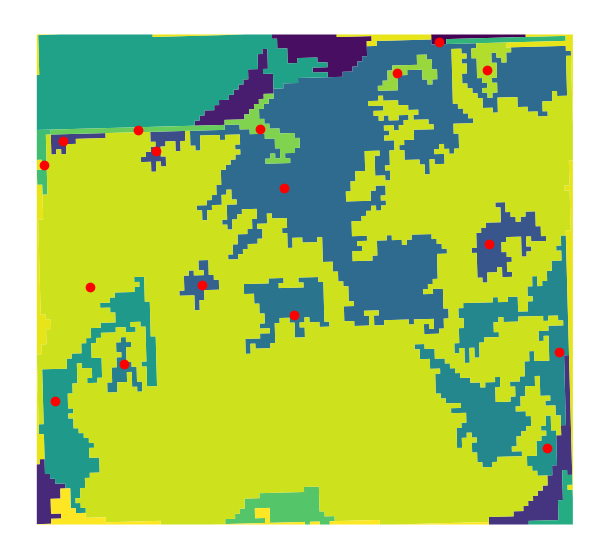

In [50]:
cluster_boundaries = run_sensor.output["result"][0].assets[0]
samples_locations = run_sensor.output["result"][0].assets[1]

s_df = gpd.read_file(samples_locations.path_or_url)
s_df = s_df[s_df.intersects(field_gs)]

c_df = gpd.read_file(cluster_boundaries.path_or_url)

fig, ax = plt.subplots(figsize=(8, 7))
c_df.plot(
    legend=True,
    scheme="quantiles",
    ax=ax,
    missing_kwds={
        "color": "lightgrey",
        "edgecolor": "red",
    },
    cmap="viridis",
)
s_df.plot(color="red", ax=ax)
plt.axis("off")